In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import shutil

root_dir = "drive/MyDrive/NewLungData"

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np

# Define data directory
data_dir = "drive/MyDrive/NewLungData"

# Define mean and standard deviation for normalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Define image size
image_size = (256, 256)

# Define batch size
batch_size = 32

# Define data generators for train, validation, and test sets
train_datagen = ImageDataGenerator(
    rescale=1./255
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'val'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5641 images belonging to 2 classes.
Found 1297 images belonging to 2 classes.
Found 1622 images belonging to 2 classes.


In [4]:
IMG_SHAPE = image_size + (3,)
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

17225924/17225924 [==============================] - 0s 0us/step


In [5]:
# Freeze convolutional base to prevent weights are being updated during training process
base_model.trainable = False

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Add a global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Add a dense layer with 256 units and ReLU activation
x = Dense(256, activation='relu')(x)

# Add dropout layer for regularization
x = tf.keras.layers.Dropout(0.5)(x)

# Add a dense layer with 128 units and ReLU activation
x = Dense(128, activation='relu')(x)

# Add dropout layer for regularization
x = tf.keras.layers.Dropout(0.5)(x)

# Add a dense layer with a single output neuron and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)


In [10]:
# Define the base learning rate
base_learning_rate = 0.0001

# Compile the model with Adam optimizer with weight decay
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate, weight_decay=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 128, 128, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 128, 128, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 128, 128, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 128, 128, 32)      128   

In [12]:
initial_epochs = 10

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_generator, epochs=initial_epochs, validation_data=val_generator,callbacks=[early_stopping])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


177/177 [==============================] - 2912s 16s/step - loss: 0.7551 - accuracy: 0.5000 - val_loss: 0.6950 - val_accuracy: 0.5000
Epoch 2/10
177/177 [==============================] - 19s 108ms/step - loss: 0.7027 - accuracy: 0.5000 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 3/10
177/177 [==============================] - 19s 108ms/step - loss: 0.6975 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 4/10
177/177 [==============================] - 19s 107ms/step - loss: 0.6955 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 5/10
177/177 [==============================] - 19s 107ms/step - loss: 0.6945 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 6/10
177/177 [==============================] - 19s 107ms/step - loss: 0.6940 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/10
177/177 [==============================] - 19s 108ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5

In [13]:
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy of', str(accuracy))

# Save the model
model_save_path =  "drive/MyDrive/NewLungData/tenserflowModels/mobilenet"

51/51 [==============================] - 665s 13s/step - loss: 0.6932 - accuracy: 0.5000
Test accuracy of 0.5


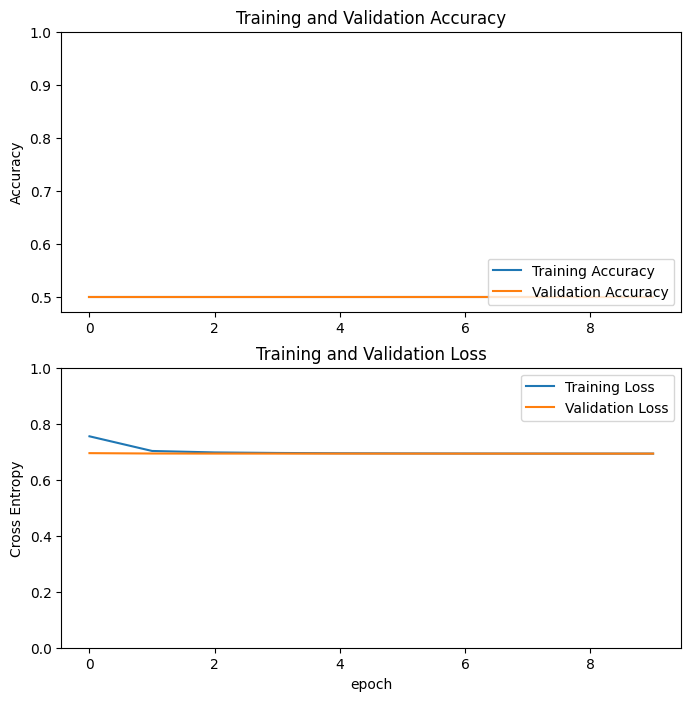

In [14]:
import matplotlib.pyplot as plt
import numpy as np
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [15]:
# No of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  86


In [16]:
# Define grid search parameters for fine-tuning layers
fine_tune_layers= [50,25,0]

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

# Perform grid search for fine-tuning layers
results = []
for fine_tune_at in fine_tune_layers:
    print("-----------------------------------------------------")
    print("Freeze the layers before layer:", fine_tune_at)
    base_model.trainable = True

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])

    print("Trainable parameters:",trainable_params)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10,weight_decay=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

    fine_tune_epochs = 10
    total_epochs =  initial_epochs + fine_tune_epochs

    # Define early stopping criteria
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history_fine = model.fit(train_generator, epochs=total_epochs, initial_epoch=history.epoch[-1],validation_data=val_generator,callbacks=[early_stopping])

    loss, accuracy = model.evaluate(test_generator)
    print('Test accuracy of',fine_tune_at,"is : ", str(accuracy))

    # File path to save the model
    model_save_path =  "drive/MyDrive/NewLungData/tenserflowModels/mobilenet_fn_"+str(no_of_fine_tune_layer)

    # Save the entire model to a single HDF5 file
    model.save(model_save_path)

-----------------------------------------------------
No Of Fine-tuning layers: 50
Trainable parameters: 2959873
Epoch 10/20
177/177 [==============================] - 30s 119ms/step - loss: 0.6952 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 11/20
177/177 [==============================] - 20s 112ms/step - loss: 0.6940 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 12/20
177/177 [==============================] - 19s 105ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 13/20
177/177 [==============================] - 19s 109ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 14/20
177/177 [==============================] - 19s 106ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 15/20
177/177 [==============================] - 19s 108ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 16/20

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


177/177 [==============================] - 29s 111ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 11/20
177/177 [==============================] - 20s 113ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 12/20
177/177 [==============================] - 20s 111ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 13/20
177/177 [==============================] - 19s 109ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 14/20
177/177 [==============================] - 20s 110ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 15/20
177/177 [==============================] - 20s 114ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 16/20
177/177 [==============================] - 21s 121ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accurac

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


177/177 [==============================] - 35s 116ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 11/20
177/177 [==============================] - 19s 105ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 12/20
177/177 [==============================] - 19s 106ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 13/20
177/177 [==============================] - 19s 108ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 14/20
177/177 [==============================] - 19s 107ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 15/20
177/177 [==============================] - 19s 108ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 16/20
177/177 [==============================] - 19s 109ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accurac